In [87]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


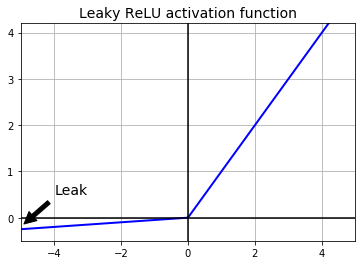

In [20]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [2]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

NameError: name 'X' is not defined

In [25]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [28]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [28]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9762
25 Batch accuracy: 1.0 Validation accuracy: 0.9774
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

# batch normalizationの重みを保存
training = tf.placeholder_with_default(False, shape=(),name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')

bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn_act, n_hidden2, name='hidden2')

bn2 = tf.layers.batch_normalization(hidden2, training=training,momentum=0.9)
bn_act2 = tf.nn.elu(bn2)

logits_before_bn =tf.layers.dense(bn_act2, n_outputs, name='outputs')
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)



In [8]:
from functools import partial
reset_graph()

batch_norm_momentum = 0.9
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [12]:
n_epochs = 20
batch_size = 200
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


In [13]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [14]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7944
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.936
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.947
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.953
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9568
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.9594
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9612


In [38]:
saver = tf.train.import_meta_graph('./my_model_final.ckpt.meta')

X = tf.get_default_graph().get_tensor_by_name('X:0')
y = tf.get_default_graph().get_tensor_by_name('y:0')
accuracy = tf.get_default_graph().get_tensor_by_name('eval/accuracy:0')
training_op = tf.get_default_graph().get_operation_by_name('GradientDescent')

for op in tf.get_default_graph().get_operations():
    print(op.name)


X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [42]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.


In [45]:
n_epochs = 20
batch_size = 200
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.964
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.965
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9688
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9682
10 Validation accuracy: 0.9706
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9706


In [ ]:
n_hidden1 =10

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.] 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')

graph = tf.get_default_graph()
assign_kernl = graph.get_operation_by_name('hidden/kernel/Assign')
assign_bias = graph.get_operation_by_name('hidden/kernel/Assign')
init_kernel = assign_kernl.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel:original_w, init_bias:original_b})
    

In [53]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4')
    logits = tf.layers.dense(hidden4, n_outputs, name='outputs')

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # 重みを凍結する層の選択
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[34]|outputs')
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [54]:
n_epochs = 20
batch_size = 200

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='hidden[123]')
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train,batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")  

FailedPreconditionError: Attempting to use uninitialized value outputs/bias
	 [[node outputs/bias/read (defined at <ipython-input-53-832a2310deff>:19) ]]

Caused by op 'outputs/bias/read', defined at:
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-832a2310deff>", line 19, in <module>
    logits = tf.layers.dense(hidden4, n_outputs, name='outputs')
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\layers\core.py", line 188, in dense
    return layer.apply(inputs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\layers\base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 538, in __call__
    self._maybe_build(inputs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1603, in _maybe_build
    self.build(input_shapes)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\keras\layers\core.py", line 958, in build
    trainable=True)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\layers\base.py", line 435, in add_weight
    getter=vs.get_variable)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 349, in add_weight
    aggregation=aggregation)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 607, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1479, in get_variable
    aggregation=aggregation)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1220, in get_variable
    aggregation=aggregation)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 547, in get_variable
    aggregation=aggregation)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 499, in _true_getter
    aggregation=aggregation)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 911, in _get_single_variable
    aggregation=aggregation)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variables.py", line 1395, in __init__
    constraint=constraint)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\util\dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3890, in identity
    "Identity", input=input, name=name)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\nsats\Anaconda3\envs\gpu-env\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value outputs/bias
	 [[node outputs/bias/read (defined at <ipython-input-53-832a2310deff>:19) ]]


In [55]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [56]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9196
1 Validation accuracy: 0.9394
2 Validation accuracy: 0.949
3 Validation accuracy: 0.953
4 Validation accuracy: 0.9554
5 Validation accuracy: 0.9558
6 Validation accuracy: 0.9578
7 Validation accuracy: 0.961
8 Validation accuracy: 0.9614
9 Validation accuracy: 0.9642
10 Validation accuracy: 0.9652
11 Validation accuracy: 0.9658
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.967
14 Validation accuracy: 0.968
15 Validation accuracy: 0.9682
16 Validation accuracy: 0.9698
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.9694
19 Validation accuracy: 0.9708


In [ ]:
learning_rate = 0.01
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_neterov=True)

optimizer = tf.train.AdagradOptimizer(learning_rate-learning_rate)

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,momentum=0.9,decay=0.9,epsilon=1e-10)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


In [58]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope('train'):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [59]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.97
1 Validation accuracy: 0.9722
2 Validation accuracy: 0.9758
3 Validation accuracy: 0.9828
4 Validation accuracy: 0.9826


In [60]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    # 正則化項を加える
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [61]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


In [64]:
from functools import partial
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name='avd_xentropy')
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name='loss')

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [65]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9222
15 Validation accuracy: 0.9218
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


In [66]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    
    # dropout
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    # dropout
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()



Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [67]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9264
1 Validation accuracy: 0.9464
2 Validation accuracy: 0.9518
3 Validation accuracy: 0.9554
4 Validation accuracy: 0.9586
5 Validation accuracy: 0.963
6 Validation accuracy: 0.9618
7 Validation accuracy: 0.9664
8 Validation accuracy: 0.968
9 Validation accuracy: 0.9702
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9708
12 Validation accuracy: 0.97
13 Validation accuracy: 0.9718
14 Validation accuracy: 0.9748
15 Validation accuracy: 0.9706
16 Validation accuracy: 0.9732
17 Validation accuracy: 0.9718
18 Validation accuracy: 0.973
19 Validation accuracy: 0.9754


In [69]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# 重み上限正則化
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

weights2 = tf.get_default_graph().get_tensor_by_name('hidden2/kernel:0')
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [70]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9566
1 Validation accuracy: 0.9704
2 Validation accuracy: 0.972
3 Validation accuracy: 0.977
4 Validation accuracy: 0.9768
5 Validation accuracy: 0.977
6 Validation accuracy: 0.9822
7 Validation accuracy: 0.9824
8 Validation accuracy: 0.979
9 Validation accuracy: 0.9822
10 Validation accuracy: 0.9818
11 Validation accuracy: 0.9834
12 Validation accuracy: 0.9812
13 Validation accuracy: 0.9832
14 Validation accuracy: 0.9842
15 Validation accuracy: 0.984
16 Validation accuracy: 0.9832
17 Validation accuracy: 0.984
18 Validation accuracy: 0.9844
19 Validation accuracy: 0.984


In [77]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [78]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [79]:
n_epochs = 20
batch_size = 50

clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9558
1 Validation accuracy: 0.97
2 Validation accuracy: 0.9724
3 Validation accuracy: 0.9754
4 Validation accuracy: 0.9772
5 Validation accuracy: 0.9788
6 Validation accuracy: 0.981
7 Validation accuracy: 0.9812
8 Validation accuracy: 0.9814
9 Validation accuracy: 0.9812
10 Validation accuracy: 0.9814
11 Validation accuracy: 0.9814
12 Validation accuracy: 0.981
13 Validation accuracy: 0.9828
14 Validation accuracy: 0.9818
15 Validation accuracy: 0.983
16 Validation accuracy: 0.9818
17 Validation accuracy: 0.9832
18 Validation accuracy: 0.9822
19 Validation accuracy: 0.9818


## 演習問題

### 8 a

In [84]:
he_int = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation=tf.nn.elu, initializer=he_int):
# variable_scope で変数を階層化
    with tf.variable_scope(name, 'dnn'):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation, 
                                     kernel_initializer=initializer, 
                                     name='hidden%d' % (layer+1))
        return inputs

n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_int, name='logits')
Y_proba = tf.nn.softmax(logits, name='Y_proba')

### 8 b

In [85]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss, name='training_op')

# in_top_k(y_pred, y_true, k)でy_predの上位k番目までの中に真値が入っていた場合、trueになる。
correct = tf.nn.in_top_k(logits, y, 1)
# tf.castで型変換を一発で行う
# tf.reduce_mean 与えたリストに入っている数値の平均値を求める関数
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
# 訓練データの削減
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [97]:
n_epochs = 10
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
    # ランダムに学習データを選ぶ
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
    # 学習training_opを実行
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    # loss ,accuracyをX,yに検証データを入れて求める
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X:X_valid1, y:y_valid1})
    # 早期打ち切りを付ける
        if loss_val < best_loss:
            save_path = saver.save(sess, 'ch11/my_mnist_model_0_to_4.ckpt')
            best_loss = loss_val
            checks_without_progress = 0
        
        else:
            checks_without_progress +=1
            if checks_without_progress > max_checks_without_progress:
                print('early stopping')
                break
                
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess,'ch11/my_mnist_model_0_to_4.ckpt')
    acc_test = sess.run(accuracy, feed_dict={X:X_test1, y:y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.378996	Best loss: 0.378996	Accuracy: 90.54%
1	Validation loss: 0.110911	Best loss: 0.110911	Accuracy: 97.22%
2	Validation loss: 0.219973	Best loss: 0.110911	Accuracy: 95.97%
3	Validation loss: 0.240473	Best loss: 0.110911	Accuracy: 91.05%
4	Validation loss: 0.113470	Best loss: 0.110911	Accuracy: 97.62%
5	Validation loss: 0.150360	Best loss: 0.110911	Accuracy: 96.36%
6	Validation loss: 0.793285	Best loss: 0.110911	Accuracy: 59.77%
7	Validation loss: 0.604311	Best loss: 0.110911	Accuracy: 90.19%
8	Validation loss: 0.380075	Best loss: 0.110911	Accuracy: 92.69%
9	Validation loss: 0.332835	Best loss: 0.110911	Accuracy: 94.41%
INFO:tensorflow:Restoring parameters from ch11/my_mnist_model_0_to_4.ckpt
Final test accuracy: 97.55%


### 8 c

In [99]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
he_init = tf.variance_scaling_initializer()

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        # 入力データのプレースホルダー
        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        # DNNの構築
        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            # get_collection で特定のスコープを取り出す
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [100]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.122529	Best loss: 0.122529	Accuracy: 96.79%
1	Validation loss: 0.162101	Best loss: 0.122529	Accuracy: 96.44%
2	Validation loss: 0.108512	Best loss: 0.108512	Accuracy: 97.38%
3	Validation loss: 0.089879	Best loss: 0.089879	Accuracy: 97.93%
4	Validation loss: 0.165096	Best loss: 0.089879	Accuracy: 96.48%
5	Validation loss: 0.137959	Best loss: 0.089879	Accuracy: 97.50%
6	Validation loss: 0.111896	Best loss: 0.089879	Accuracy: 97.54%
7	Validation loss: 0.130334	Best loss: 0.089879	Accuracy: 97.26%
8	Validation loss: 0.610585	Best loss: 0.089879	Accuracy: 78.34%
9	Validation loss: 0.322547	Best loss: 0.089879	Accuracy: 97.11%
10	Validation loss: 0.812121	Best loss: 0.089879	Accuracy: 92.22%
11	Validation loss: 1.363133	Best loss: 0.089879	Accuracy: 34.36%
12	Validation loss: 1.379614	Best loss: 0.089879	Accuracy: 38.15%
13	Validation loss: 1.362691	Best loss: 0.089879	Accuracy: 35.38%
14	Validation loss: 1.556379	Best loss: 0.089879	Accuracy: 26.82%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x000001C7E379E7B8>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001C8AF7574A8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [101]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9785950574041642

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)

### 8 d

In [105]:
def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu


dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.083823	Best loss: 0.083823	Accuracy: 97.50%
1	Validation loss: 0.055118	Best loss: 0.055118	Accuracy: 98.28%
2	Validation loss: 0.040665	Best loss: 0.040665	Accuracy: 98.75%
3	Validation loss: 0.056053	Best loss: 0.040665	Accuracy: 98.48%
4	Validation loss: 0.044132	Best loss: 0.040665	Accuracy: 98.48%
5	Validation loss: 0.037938	Best loss: 0.037938	Accuracy: 98.55%
6	Validation loss: 0.039892	Best loss: 0.037938	Accuracy: 98.94%
7	Validation loss: 0.051411	Best loss: 0.037938	Accuracy: 98.51%
8	Validation loss: 0.051926	Best loss: 0.037938	Accuracy: 98.91%
9	Validation loss: 0.063269	Best loss: 0.037938	Accuracy: 98.59%
10	Validation loss: 0.045566	Best loss: 0.037938	Accuracy: 98.83%
11	Validation loss: 0.062851	Best loss: 0.037938	Accuracy: 98.63%
12	Validation loss: 0.058805	Best loss: 0.037938	Accuracy: 98.75%
13	Validation loss: 0.065914	Best loss: 0.037938	Accuracy: 98.63%
14	Validation loss: 0.073791	Best loss: 0.037938	Accuracy: 98.44%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001C8B22F6048>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001C8AF7574A8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [106]:
from sklearn.metrics import accuracy_score
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9918272037361354

In [107]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.
0	Validation loss: 0.044999	Best loss: 0.044999	Accuracy: 98.71%
1	Validation loss: 0.038797	Best loss: 0.038797	Accuracy: 98.67%
2	Validation loss: 0.038604	Best loss: 0.038604	Accuracy: 98.91%
3	Validation loss: 0.064228	Best loss: 0.038604	Accuracy: 97.77%
4	Validation loss: 0.049275	Best loss: 0.038604	Accuracy: 98.51%
5	Validation loss: 0.029667	Best loss: 0.029667	Accuracy: 99.14%
6	Validation loss: 0.030725	Best loss: 0.029667	Accuracy: 99.18%
7	Validation loss: 0.038786	Best loss: 0.029667	Accuracy: 98.83%
8	Validation loss: 0.026140	Best loss: 0.026140	Accuracy: 99.14%
9	Validation loss: 0.029221	Best loss: 0.026140	Accuracy: 99.18%
10	Validation loss: 0.034903	Best loss: 0.026140	Accuracy: 99.02%
11	Validation loss: 0.044801	Best loss: 0.026140	Accuracy: 98.71%
12	Validation loss: 0.040226	Best loss: 0.026140	Accuracy: 99.02%
13	Validation loss: 0.043110	Be

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001C8BAAE9C80>,
              batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001C8AF7574A8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [108]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9933839268340144

### 8 E

In [109]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.132864	Best loss: 0.132864	Accuracy: 96.64%
1	Validation loss: 0.094044	Best loss: 0.094044	Accuracy: 97.11%
2	Validation loss: 0.096225	Best loss: 0.094044	Accuracy: 97.65%
3	Validation loss: 0.092083	Best loss: 0.092083	Accuracy: 97.69%
4	Validation loss: 0.079092	Best loss: 0.079092	Accuracy: 97.85%
5	Validation loss: 0.070968	Best loss: 0.070968	Accuracy: 97.93%
6	Validation loss: 0.073465	Best loss: 0.070968	Accuracy: 98.24%
7	Validation loss: 0.075080	Best loss: 0.070968	Accuracy: 98.20%
8	Validation loss: 0.076732	Best loss: 0.070968	Accuracy: 98.08%
9	Validation loss: 0.074943	Best loss: 0.070968	Accuracy: 98.44%
10	Validation loss: 0.073864	Best loss: 0.070968	Accuracy: 98.01%
11	Validation loss: 0.074112	Best loss: 0.070968	Accuracy: 98.08%
12	Validation loss: 0.065631	Best loss: 0.065631	Accuracy: 98.24%
13	Validation loss: 0.063012	Best loss: 0.063012	Accuracy: 98.32%
14	Validation loss: 0.065266	Best loss: 0.063012	Accuracy: 98.24%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001C8BABB7BF8>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001C8AF7574A8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [110]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9856003113446196

### 9 a

In [129]:
reset_graph()

restore_saver = tf.train.import_meta_graph('ch11/my_mnist_model_0_to_4.ckpt.meta')
    
# get_tensor_by_name 特定のTensorを取得する
X = tf.get_default_graph().get_tensor_by_name('X:0')
y =tf.get_default_graph().get_tensor_by_name('y:0')
loss = tf.get_default_graph().get_tensor_by_name('loss:0')
Y_proba = tf.get_default_graph().get_tensor_by_name('Y_proba:0')
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name('accuracy:0')

learning_rate = 0.01

# get_collectionで特定の名前スコープに対して操作を行える。GraphKeys.TRAINABLE_VARIABLES で訓練可能な変数と設定
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='logits')
optimizer = tf.train.AdamOptimizer(learning_rate, name='Adam2')
# var_listでオプティマイザに更新する変数のリストを渡せる
training_op = optimizer.minimize(loss,var_list=output_layer_vars)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()


### 9 b

In [130]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [131]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [132]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [134]:
import time
n_epochs = 100
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    # 変数を呼び込む
    restore_saver.restore(sess, 'ch11/my_mnist_model_0_to_4.ckpt')
    t0 = time.time()
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2)//batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        loss_val, loss_acc = sess.run([loss,accuracy], feed_dict={X:X_valid2, y:y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, 'ch11/my_mnist_model_5_to_9_five_frozen')
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('early stopping')
                break
        
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
    
    t1 = time.time()
    print('Total training time: {:.1f}s'.format(t1-t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, 'ch11/my_mnist_model_5_to_9_five_frozen')
    acc_test = accuracy.eval(feed_dict={X:X_test2, y:y_test2})
    print('final accuracy: {:.2f}%'.format(acc_test*100))

INFO:tensorflow:Restoring parameters from ch11/my_mnist_model_0_to_4.ckpt
0	Validation loss: 2.073083	Best loss: 2.073083	Accuracy: 94.41%
1	Validation loss: 1.616588	Best loss: 1.616588	Accuracy: 94.41%
2	Validation loss: 1.433028	Best loss: 1.433028	Accuracy: 94.41%
3	Validation loss: 1.334913	Best loss: 1.334913	Accuracy: 94.41%
4	Validation loss: 1.286134	Best loss: 1.286134	Accuracy: 94.41%
5	Validation loss: 1.472596	Best loss: 1.286134	Accuracy: 94.41%
6	Validation loss: 1.281950	Best loss: 1.281950	Accuracy: 94.41%
7	Validation loss: 1.319315	Best loss: 1.281950	Accuracy: 94.41%
8	Validation loss: 1.664335	Best loss: 1.281950	Accuracy: 94.41%
9	Validation loss: 1.409579	Best loss: 1.281950	Accuracy: 94.41%
10	Validation loss: 1.294340	Best loss: 1.281950	Accuracy: 94.41%
11	Validation loss: 1.358120	Best loss: 1.281950	Accuracy: 94.41%
12	Validation loss: 1.264460	Best loss: 1.264460	Accuracy: 94.41%
13	Validation loss: 1.327769	Best loss: 1.264460	Accuracy: 94.41%
14	Validatio

### 9 c

In [174]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("dnn/hidden5/Elu:0")

### 9 d

In [172]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("ch11/my_mnist_model_0_to_4.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

#  4層目の出力を取得
hidden4_out = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Elu:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

# 隠れ層４層目と出力層を訓練可能にする
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")

training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [173]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "ch11/my_mnist_model_0_to_4.ckpt")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "ch11/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "ch11/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ch11/my_mnist_model_0_to_4.ckpt
0	Validation loss: 2.789467	Best loss: 2.789467	Accuracy: 47.33%
1	Validation loss: 1.841614	Best loss: 1.841614	Accuracy: 46.00%
2	Validation loss: 1.936504	Best loss: 1.841614	Accuracy: 45.33%
3	Validation loss: 1.454504	Best loss: 1.454504	Accuracy: 52.00%
4	Validation loss: 1.558626	Best loss: 1.454504	Accuracy: 44.67%
5	Validation loss: 1.478964	Best loss: 1.454504	Accuracy: 45.33%
6	Validation loss: 1.414275	Best loss: 1.414275	Accuracy: 53.33%
7	Validation loss: 1.208015	Best loss: 1.208015	Accuracy: 51.33%
8	Validation loss: 2.046711	Best loss: 1.208015	Accuracy: 32.00%
9	Validation loss: 1.574036	Best loss: 1.208015	Accuracy: 40.67%
10	Validation loss: 1.832989	Best loss: 1.208015	Accuracy: 45.33%
11	Validation loss: 1.845016	Best loss: 1.208015	Accuracy: 40.67%
12	Validation loss: 1.386157	Best loss: 1.208015	Accuracy: 46.00%
13	Validation loss: 1.461256	Best loss: 1.208015	Accuracy: 43.33%
14	Validatio

### 9 e

In [175]:
learning_rate = 0.01



# 隠れ層４層目と出力層を訓練可能にする
unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")

training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [176]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "ch11/my_mnist_model_0_to_4.ckpt")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "ch11/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "ch11/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ch11/my_mnist_model_0_to_4.ckpt
0	Validation loss: 2.838898	Best loss: 2.838898	Accuracy: 37.33%
1	Validation loss: 1.837588	Best loss: 1.837588	Accuracy: 52.00%
2	Validation loss: 1.526819	Best loss: 1.526819	Accuracy: 54.67%
3	Validation loss: 1.457405	Best loss: 1.457405	Accuracy: 50.00%
4	Validation loss: 1.732809	Best loss: 1.457405	Accuracy: 48.00%
5	Validation loss: 1.461506	Best loss: 1.457405	Accuracy: 51.33%
6	Validation loss: 1.671328	Best loss: 1.457405	Accuracy: 44.00%
7	Validation loss: 1.822386	Best loss: 1.457405	Accuracy: 44.67%
8	Validation loss: 1.759439	Best loss: 1.457405	Accuracy: 46.00%
9	Validation loss: 1.411399	Best loss: 1.411399	Accuracy: 45.33%
10	Validation loss: 1.835194	Best loss: 1.411399	Accuracy: 40.67%
11	Validation loss: 1.877978	Best loss: 1.411399	Accuracy: 39.33%
12	Validation loss: 1.648495	Best loss: 1.411399	Accuracy: 39.33%
13	Validation loss: 1.927988	Best loss: 1.411399	Accuracy: 44.00%
14	Validatio

### 10 a

In [184]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name='X')
# tensorを二つに分割する
X1, X2 = tf.unstack(X, axis=1)

# 二つの数値が等しければ１、異なれば０のラベルをつける
y =tf.placeholder(tf.int32, shape=[None,1])

he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation=tf.nn.elu, initializer=he_int):
# variable_scope で変数を階層化
    with tf.variable_scope(name, 'dnn'):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation, 
                                     kernel_initializer=initializer, 
                                     name='hidden%d' % (layer+1))
        return inputs


dnn1 = dnn(X1, name='DNN_A')
dnn2 = dnn(X2, name='DNN_B')

# 二つのネットワークの出力をまとめる
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

print(dnn1.shape)
print(dnn2.shape)
print(dnn_outputs.shape)

hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

# tf.greater_equal で二つの値のうち、大きいほうを返す
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)
y_as_float = tf.cast(y, tf.float32)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

(?, 100)
(?, 100)
(?, 200)


### 10 b

In [187]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [192]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

(5, 2, 784) float32
[[0]
 [0]
 [0]
 [1]
 [1]]


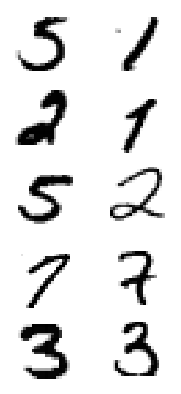

In [204]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

print(X_batch.shape, X_batch.dtype)
print(y_batch)

plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [206]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X:X_batch, y:y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X:X_test1, y:y_test1})
            print(epoch, "Test accuracy:", acc_test)
            
        save_path = saver.save(sess, 'ch11/my_digit_comparison_model.ckpt')

0 Train loss: 0.69176936
0 Test accuracy: 0.5244
1 Train loss: 0.57125527
2 Train loss: 0.55620176
3 Train loss: 0.5481904
4 Train loss: 0.45125982
5 Train loss: 0.43640688
5 Test accuracy: 0.8018
6 Train loss: 0.42479438
7 Train loss: 0.33413723
8 Train loss: 0.4036409
9 Train loss: 0.35863727
10 Train loss: 0.3600116
10 Test accuracy: 0.8563
11 Train loss: 0.30332038
12 Train loss: 0.28044146
13 Train loss: 0.25412467
14 Train loss: 0.27061003
15 Train loss: 0.2567548
15 Test accuracy: 0.8989
16 Train loss: 0.26206276
17 Train loss: 0.2399947
18 Train loss: 0.16286466
19 Train loss: 0.19637285
20 Train loss: 0.1819351
20 Test accuracy: 0.9201
21 Train loss: 0.17858937
22 Train loss: 0.17267565
23 Train loss: 0.17332488
24 Train loss: 0.18316536
25 Train loss: 0.16704723
25 Test accuracy: 0.9382
26 Train loss: 0.13938135
27 Train loss: 0.13096334
28 Train loss: 0.12862495
29 Train loss: 0.09602224
30 Train loss: 0.0830857
30 Test accuracy: 0.95
31 Train loss: 0.122175954
32 Train loss